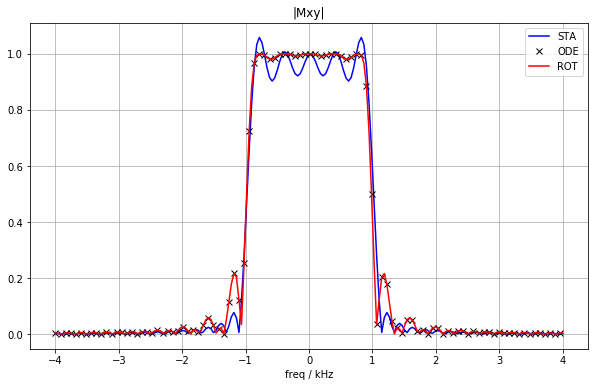

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

"""
off-resonance exictation: 5 ms sinc pulse (b1 field on x-axis, no relaxation)
"""
import numpy as np
from scipy.integrate import odeint  #integrate ODEs 

T      = np.linspace(0,5,200)                       # time axis [ms]
dt     = T[1]-T[0]                                  # time increment
F      = np.linspace(-2*np.pi*4,2*np.pi*4,200)      # offset frequencies [rad/ms]
w      = np.pi/2                                    # tip-angle [rad] 
def shape(t): return np.sinc(2*(t-2.5))             # sinc RF pulse 
v = w/np.trapz(shape(T),T)                          # normalized tip-angle

# STA SOLUTION using fft
N  = np.int(0.5*F.size*np.pi/dt/np.max(F))*2;       # number of points on fft
M_STA = np.sin(w)*np.abs(np.fft.fftshift(np.fft.fft(shape(T),N))) * dt*v/w;
M_STA = M_STA[N/2-F.size/2:N/2+F.size/2];           # extract frequencies of interest

M_ODE = np.zeros(F.size); M_ROT = np.zeros(F.size)  #intialize result vectors  
for i, freq in enumerate(F, start=0):
    # ODE SOLUTION
    def bloch(M,t,v,freq): return [ freq*M[1], -freq*M[0]+v*shape(t)*M[2], -v*shape(t)*M[1]]
    M = odeint(bloch, [0.,0.,1.], T,(v,freq))                        # integrate ODE
    M_ODE[i]=np.sqrt(M[-1,0]**2+M[-1,1]**2)                          # transv. magn. 
    # ROTATION MATRIX SOLUTION
    Q  = np.eye(2,dtype=complex)                                     # init Cayley-Klein matrix
    for t in T:
        W = -dt*np.sqrt(np.abs(v*shape(t))**2+freq**2)               # effective field rotation angle 
        n = (dt/np.abs(W)) * np.array([v*shape(t), 0, freq])         # effective field rotation axis
        a = np.cos(W/2)-1j*n[2]*np.sin(W/2)                          # Cayley-Klein parameter alpha             
        b = (-1j*n[0]+n[1])*np.sin(W/2)                              # Cayley-Klein parameter beta 
        Q = np.dot(np.array([[a, -np.conj(b)],[b, np.conj(a)]]),Q )  # chained rotation 
    M_ROT[i]=np.abs(2*np.conj(Q[0,0])*Q[1,0])                        # transv. magn. 

    
"""
plot results
"""
F = F/(2*np.pi)
plt.figure(figsize=(10, 6))
plt.plot(F     , M_STA         , "b" ,    label="STA")
plt.plot(F[::2], M_ODE[::2]    , "kx",    label="ODE")
plt.plot(F     , np.abs(M_ROT) , "r" ,  label="ROT")
plt.xlabel("freq / kHz"); plt.title("|Mxy|"); plt.legend(loc='upper right')
plt.grid(True); plt.show()


